# Introduction to Generative Adversarial Networks (GANs) (Chapter 17) 🎨

---

This notebook introduces the fundamentals of **Generative Adversarial Networks (GANs)**, the subject of **Chapter 17: Generative Adversarial Networks for Synthesizing New Data**. Moving beyond discriminative models (which classify data) and sequence models (which predict the next token), GANs focus on **data synthesis**—learning to generate entirely new, realistic data samples that resemble a training distribution.

### 1. The Adversarial Framework: Generator vs. Discriminator ⚔️

The core of a GAN is a "game" played between two neural networks:

* **The Generator ($G$):** This network takes a vector of random noise ($z$) as input and attempts to transform it into a realistic data sample (e.g., an image of a digit). In this notebook, the generator is a fully connected network using **`LeakyReLU`** activations and a final **`Tanh`** activation to map outputs to the normalized image range.
* **The Discriminator ($D$):** This network acts as a binary classifier. It receives either a "real" sample from the training set or a "fake" sample from the generator and must decide which is which. It utilizes **`LeakyReLU`**, **`Dropout`** for regularization, and a **`Sigmoid`** output layer to produce a probability of the input being "real".



### 2. Data Preparation and Preprocessing 🖼️

The notebook applies the GAN framework to the **MNIST dataset** of handwritten digits:

* **Normalization:** Input images are normalized to the range **$[-1, 1]$** using `transforms.Normalize((0.5,), (0.5,))`. This matches the `Tanh` output of the generator, which is a standard practice for stable GAN training.
* **Latent Space ($z$):** The generator's input is a "latent vector" of random noise, typically sampled from a **uniform** or **normal distribution**. This noise serves as the "seed" for generating variety in the output.

### 3. Adversarial Training Dynamics 🔄

Training a GAN is unique because it involves a **minimax game** where the two networks are trained simultaneously but with opposing goals:

* **Discriminator Training (`d_train`):** The objective is to maximize the probability of correctly labeling real images as `1` and fake images as `0`. The loss is calculated using **`nn.BCELoss`** (Binary Cross Entropy) for both real and fake batches.
* **Generator Training (`g_train`):** The generator's goal is to produce samples that the discriminator classifies as real. To do this, it is trained to **maximize** the discriminator's output for fake samples (or minimize the loss when the target is set to `1`).
* **Optimization:** The notebook uses the **Adam optimizer** for both networks, which is the preferred choice for handling the complex gradients of adversarial training.



### 4. Evaluating Progress: Generating Samples ✍️

To monitor the model's progress, the notebook includes a utility to periodically generate and visualize images from a fixed set of noise vectors (`fixed_z`). Over many epochs, the initially random noise produced by the generator should gradually transform into recognizable digits as it learns to mimic the patterns found in the MNIST training set.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

In [ ]:
print(torch.__version__)

2.8.0+cu126


In [ ]:
print('GPU Available:', torch.cuda.is_available())

GPU Available: True


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Device:', device)

Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def make_generator_network(
    input_size= 20,
    num_hidden_layers= 1,
    num_hidden_units= 100,
    num_output_units= 784):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(
        f'fc_g{i+1}',
        nn.Linear(input_size, num_hidden_units))
    model.add_module(f'relu_g{i+1}', nn.LeakyReLU())
    input_size = num_hidden_units

  model.add_module(
    f'fc_g{num_hidden_layers+1}',
    nn.Linear(input_size, num_output_units))
  model.add_module(f'tanh_g', nn.Tanh())

  return model


In [ ]:
def make_discriminator_network(
    input_size,
    num_hidden_layers= 1,
    num_hidden_units= 100,
    num_output_units= 1):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(
        f'fc_d{i+1}',
        nn.Linear(input_size, num_hidden_units, bias= False))
    model.add_module(f'relu_d{i+1}', nn.LeakyReLU())
    model.add_module(f'dropout{i+1}', nn.Dropout(0.5))
    input_size = num_hidden_units

  model.add_module(
    f'fc_d{num_hidden_layers+1}',
    nn.Linear(input_size, num_output_units))
  model.add_module(f'sigmoid', nn.Sigmoid())

  return model


In [ ]:
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_units = 100
dis_hidden_layers = 1
dis_hidden_units = 100

gen_model = make_generator_network(
    input_size= z_size,
    num_hidden_layers= gen_hidden_layers,
    num_hidden_units= gen_hidden_units,
    num_output_units= np.prod(image_size))

disc_model = make_discriminator_network(
    input_size= np.prod(image_size),
    num_hidden_layers= dis_hidden_layers,
    num_hidden_units= dis_hidden_units)


In [ ]:
print(gen_model)

Sequential(
  (fc_g1): Linear(in_features=20, out_features=100, bias=True)
  (relu_g1): LeakyReLU(negative_slope=0.01)
  (fc_g2): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [ ]:
print(disc_model)

Sequential(
  (fc_d1): Linear(in_features=784, out_features=100, bias=False)
  (relu_d1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc_d2): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
from torchvision import datasets, transforms

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

image_path = './'
mnist_dataset = datasets.MNIST(
    root= image_path,
    train= True,
    download= True,
    transform= transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.54MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.80MB/s]


In [ ]:
example, label = next(iter(mnist_dataset))
print(example.shape, label)
print(f'Min: {example.min()} Max: {example.max()}')

torch.Size([1, 28, 28]) 5
Min: -1.0 Max: 1.0


In [ ]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size) * 2 - 1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size)
  return input_z

In [ ]:
batch_size = 32
data_loader = DataLoader(
    mnist_dataset,
    batch_size= batch_size,
    shuffle= False)
input_real, label = next(iter(data_loader))
input_real = input_real.view(batch_size, -1)
mode_z = 'uniform'
input_z = create_noise(batch_size, z_size, mode_z)
print(f'input_real: {input_real.shape}')
print(f'input_z: {input_z.shape}')

input_real: torch.Size([32, 784])
input_z: torch.Size([32, 20])


In [ ]:
g_output = gen_model(input_z)
print(f'Output G --shape: {g_output.shape}')

Output G --shape: torch.Size([32, 784])


In [ ]:
d_prob_fake = disc_model(g_output)
d_prob_real = disc_model(input_real)
print(f'Output D --shape: {d_prob_fake.shape}')
print(f'Output D --shape: {d_prob_real.shape}')

Output D --shape: torch.Size([32, 1])
Output D --shape: torch.Size([32, 1])


In [ ]:
loss_fn = nn.BCELoss()
g_labels_real = torch.ones_like(d_prob_fake)
g_loss = loss_fn(d_prob_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')

Generator Loss: 0.6779


In [ ]:
d_labels_fake = torch.zeros_like(d_prob_fake)
d_labels_real = torch.ones_like(d_prob_real)
d_loss_real = loss_fn(d_prob_real, d_labels_real)
d_loss_fake = loss_fn(d_prob_fake, d_labels_fake)
print(f'Discriminator Loss: Real {d_loss_real:.4f}, Fake {d_loss_fake:.4f}')

Discriminator Loss: Real 0.8370, Fake 0.7092


In [ ]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset, batch_size= batch_size,
                        shuffle= True, drop_last= True)
gen_model = make_generator_network(
    input_size= z_size,
    num_hidden_layers= gen_hidden_layers,
    num_hidden_units= gen_hidden_units,
    num_output_units= np.prod(image_size)
    ).to(device)
disc_model = make_discriminator_network(
    input_size= np.prod(image_size),
    num_hidden_layers= dis_hidden_layers,
    num_hidden_units= dis_hidden_units
).to(device)
loss_fn = nn.BCELoss()
g_optimizer = optim.Adam(gen_model.parameters(), lr= 0.001)
d_optimizer = optim.Adam(disc_model.parameters(), lr= 0.001)

In [ ]:
def d_train(x):
  disc_model.zero_grad()
  batch_size = x.size(0)
  x = x.view(batch_size, -1).to(device)
  d_labels_real = torch.ones(batch_size, 1, device= device)
  d_prob_real = disc_model(x)
  d_loss_real = loss_fn(d_prob_real, d_labels_real)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_prob_fake = disc_model(g_output)
  d_labels_fake = torch.zeros(batch_size, 1, device= device)
  d_loss_fake = loss_fn(d_prob_fake, d_labels_fake)
  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()
  return d_loss.data.item(), d_prob_real.detach(), d_prob_fake.detach()

In [ ]:
def g_train(x):
  gen_model.zero_grad()
  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_prob_fake = disc_model(g_output)
  g_prob_real = torch.ones(batch_size, 1, device= device)
  g_loss = loss_fn(d_prob_fake, g_prob_real)
  g_loss.backward()
  g_optimizer.step()
  return g_loss.data.item()

In [ ]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
def create_samples(gen_model, input_z):
  g_output = gen_model(input_z)
  images = torch.reshape(g_output, (batch_size, *images))
  return (images+1)/2.0

In [ ]:
epoch_samples, all_d_losses, all_g_losses = [], [], []
all_d_real, all_d_fake = [], []
num_epochs = 100
for epoch in range(num_epochs):
  g_losses, d_losses = [], []
  d_vals_real, d_vals_fake = [], []
  for i, (x, _) in enumerate(mnist_dl):
    d_loss, d_prob_real, d_prob_fake = d_train(x)
    g_loss = g_train(x)
    g_losses.append(g_loss)
    d_losses.append(d_loss)
    d_vals_real.append(d_prob_real.mean().cpu())
    d_vals_fake.append(d_prob_fake.mean().cpu())
  all_d_losses.append(torch.tensor(d_losses).mean())
  all_g_losses.append(torch.tensor(g_losses).mean())
  all_d_real.append(torch.tensor(d_vals_real).mean())
  all_d_fake.append(torch.tensor(d_vals_fake).mean())

  print(
      f'Epoch {(epoch+1):03d} Average Losses >>'
      f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
      f' [D Real: {all_d_real[-1]:.4f}'
      f' D fake: {all_d_fake[-1]:.4f}]'
      )
  epoch_samples.append(
      create_samples(gen_model, fixed_z).detach().cpu().numpy()
  )

Epoch 001 Average Losses >> G/D 0.9190/1.1743 [D Real: 0.5951 D fake: 0.4408]
Epoch 002 Average Losses >> G/D 0.8872/1.2300 [D Real: 0.5701 D fake: 0.4411]
Epoch 003 Average Losses >> G/D 0.8602/1.2619 [D Real: 0.5512 D fake: 0.4444]
Epoch 004 Average Losses >> G/D 1.0068/1.1713 [D Real: 0.5920 D fake: 0.4080]
Epoch 005 Average Losses >> G/D 0.9355/1.2385 [D Real: 0.5688 D fake: 0.4335]
Epoch 006 Average Losses >> G/D 0.8739/1.2499 [D Real: 0.5617 D fake: 0.4388]
Epoch 007 Average Losses >> G/D 0.9198/1.2322 [D Real: 0.5677 D fake: 0.4297]
Epoch 008 Average Losses >> G/D 0.9599/1.1923 [D Real: 0.5860 D fake: 0.4156]
Epoch 009 Average Losses >> G/D 1.0369/1.1640 [D Real: 0.6003 D fake: 0.4023]
Epoch 010 Average Losses >> G/D 1.1424/1.0911 [D Real: 0.6266 D fake: 0.3740]
Epoch 011 Average Losses >> G/D 1.0295/1.1651 [D Real: 0.6011 D fake: 0.4025]
Epoch 012 Average Losses >> G/D 0.9958/1.2027 [D Real: 0.5860 D fake: 0.4142]
Epoch 013 Average Losses >> G/D 1.0178/1.1710 [D Real: 0.5986 D 

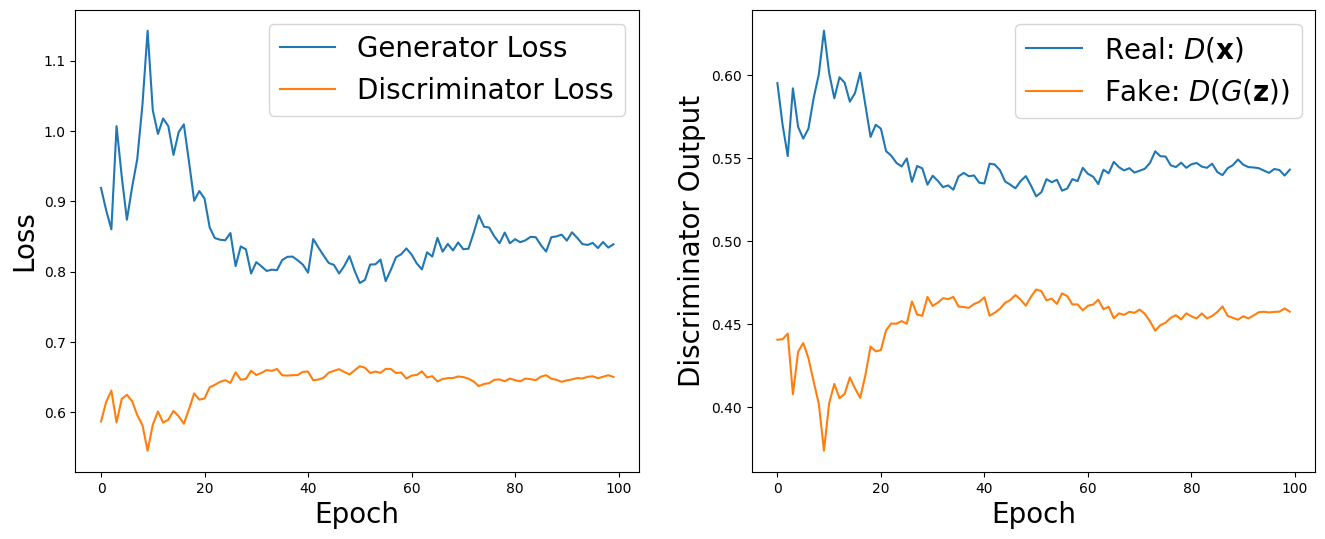

In [ ]:
import itertools
import matplotlib.pyplot as plt
fig = plt.figure(figsize= (16, 6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label= 'Generator Loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label= 'Discriminator Loss')
plt.legend(fontsize= 20)
ax.set_xlabel('Epoch', fontsize= 20)
ax.set_ylabel('Loss', fontsize= 20)
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label= r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize= 20)
ax.set_xlabel('Epoch', fontsize= 20)
ax.set_ylabel('Discriminator Output', fontsize= 20)
plt.show()

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
for i, e in enumerate(selected_epochs):
  fig = plt.figure(figsize= (14, 16))
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
      -0.06, 0.5, f'Epoch {e}',
      rotation=90, size=18, color='red',
      horizontalalignment='right',
      verticalalignment='center',
      transform=ax.transAxes
      )
    image = epoch_samples[e-1][j]
    plt.imshow(image, cmap= 'gray')
  plt.show()
  plt.savefig

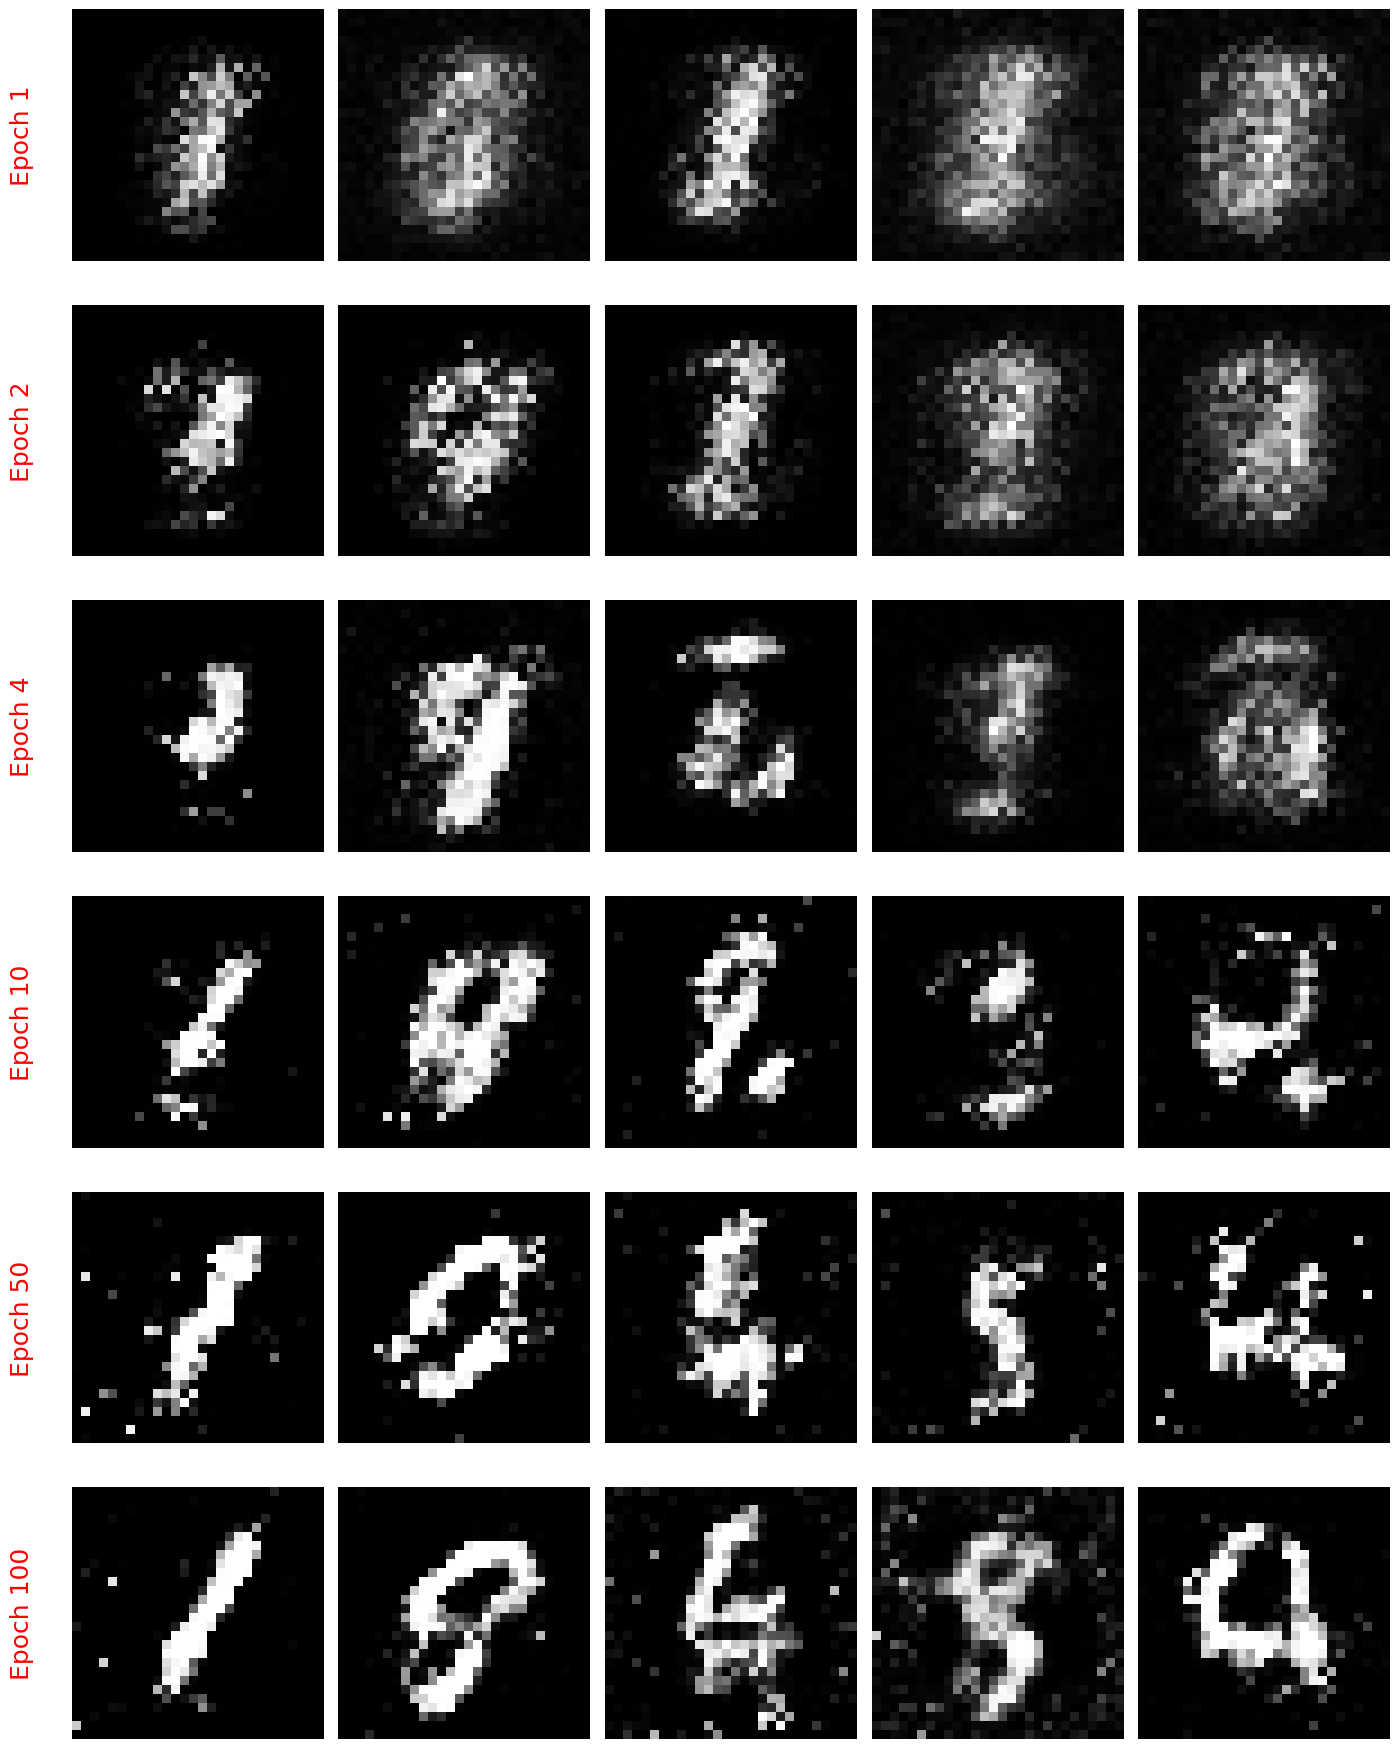

Combined sample image saved to './generated_samples_combined' directory.


In [ ]:
import os
import matplotlib.pyplot as plt

# Create a directory to save the images if it doesn't exist
save_dir = './generated_samples_combined'
os.makedirs(save_dir, exist_ok=True)

selected_epochs = [1, 2, 4, 10, 50, 100]
num_epochs_to_show = len(selected_epochs) # Show all selected epochs in one plot
num_samples_per_epoch = 5 # Number of samples to show for each epoch

fig, axes = plt.subplots(num_epochs_to_show, num_samples_per_epoch, figsize=(14, num_epochs_to_show * 3))

for i, e in enumerate(selected_epochs):
  for j in range(num_samples_per_epoch):
    ax = axes[i, j]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(epoch_samples[e-1][j], cmap= 'gray')
    ax.axis('off')
    if j == 0:
      ax.text(
      -0.15, 0.5, f'Epoch {e}',
      rotation=90, size=18, color='red',
      horizontalalignment='right',
      verticalalignment='center',
      transform=ax.transAxes
      )

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'all_epochs_samples_combined.png'))
plt.show()

print(f"Combined sample image saved to '{save_dir}' directory.")